# Does a County's Metropolitan Status Impact the Susceptibility to Depression/Mental Health Issues among Individuals age 18 and above in the United States? 

## Introduction

**Specific Problem.** [to be inserted]

**Analytical COntext.** [to be inserted]

The Statistical Analysis jupyter notebook will proceed as follows: we will (1) explore the relationship of available features with the interested outcome variable (Any_Mental_Illness_Indicator_Past_Year) using logistic regression; (2) discuss feature engineering (if applicable/need); (3) Bivariate Analysis using Chi-Square/Regression; and (4) Multivariate Analysis with Feature Selection (Forward/Backward/Mixed/other methods) to study the importance of other features in relation to our interested outcome variable.

**Hypothesis**
H_0: Metropolitan Status and Susceptibility to Mental Health Issues are independent
H_A: Metropolitan Status and Susceptibility to Mental Health Issues are not independent

In [1]:
# import libraries we will be using:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
import pingouin
%matplotlib inline

# Adjust notebook settings to widen the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# read in the data
df = pd.read_csv("./Data/nsduh_data_cleaned.csv")
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1) # remove not informative columns
df.head()
df.shape

X = df.drop(['Any_Mental_Illness_Indicator_Past_Year', 'Identifier'], axis=1) # independent variables data
y = df['Any_Mental_Illness_Indicator_Past_Year']  # dependent variable data

X.shape, y.shape # print X and y's data shape

In [5]:
# # statistics of dataset
# print(df.describe())
# print("-"*60)
# print(df.info())

         Identifier           Year  Inpatient_Past_Year  Outpatient_Past_Year  \
count  2.145050e+05  214505.000000        214505.000000         214505.000000   
mean   5.444097e+07    2016.994205             0.007781              0.077896   
std    2.557156e+07       1.417236             0.125119              0.290238   
min    1.000061e+07    2015.000000            -1.000000             -1.000000   
25%    3.199510e+07    2016.000000             0.000000              0.000000   
50%    5.404454e+07    2017.000000             0.000000              0.000000   
75%    7.606595e+07    2018.000000             0.000000              0.000000   
max    1.000000e+08    2019.000000             1.000000              1.000000   

       Prescription_Treatment_Past_Year  Any_Treatment_Past_Year  \
count                     214505.000000            214505.000000   
mean                           0.122738                 0.151833   
std                            0.342022                 0.376175  

In [35]:
df.head()

,Identifier,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Treatment_Type_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didn’t_Think_Would_Help,No_Treatment_Didn’t_Have_Time,No_Treatment_Didn’t_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Mental_Illness_Indicator_Past_Year,Any_Mental_Illness_Indicator_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Gender,Age_Category,Age_Category_Three_Levels,Age_Category_Five_Levels,Age_Category_Six_Levels,Gender_Age_Category,NEWRACE2,Race_Age,Education_Category,Overall_Health,Work_Situation_Past_Week,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Adult_Employment_Status,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Total_Income_Family,Participated_In_One_Or_More_Government_Assistance_Programs,Total_Income_Family_Recode,Poverty_Level,Population_Density_2010,County_Metro_NonMetro_Status
0,13005143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,4,3,4,4,5,7,5,2,1,1,0,0,1,0,1,0,0,-1,1,1,0,0,1,0,1,1,2,4,1,2,2,2,2
1,67415143,2015,0,1,1,1,6,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,0,11,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,3,3,3,3,5,1,2,4,2,7,0,0,4,0,0,0,1,-1,1,1,0,0,0,0,0,0,1,1,0,1,1,2,3
2,75235143,2015,0,1,1,1,6,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,6,-1,11,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,-1,2,2,2,2,2,4,1,2,3,3,6,0,0,4,0,0,0,1,-1,1,1,0,0,0,0,0,0,1,2,0,1,1,3,3
3,47745143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,8,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,-1,1,2,2,2,2,3,5,7,3,3,7,0,0,4,0,0,0,1,-1,1,1,0,0,0,0,0,0,1,1,0,1,1,1,1
4,33145143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,2,2,2,2,3,7,5,2,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0,2,3,2,2


In [6]:
df["Any_Mental_Illness_Indicator_Past_Year"].value_counts()

0    166553
1     47952
Name: Any_Mental_Illness_Indicator_Past_Year, dtype: int64

Target class has two classes: 
* 1 (Has indication of mental illness past year) = 47,952 people
* 2 (Has no indication of mental illness past year) = 166,553 people

# Bivariate Analysis

In [7]:
df_contingency_table = pd.crosstab(index=df["Any_Mental_Illness_Indicator_Past_Year"], columns=df["County_Metro_NonMetro_Status"], normalize="columns")*100
df_contingency_table

County_Metro_NonMetro_Status,1,2,3
Any_Mental_Illness_Indicator_Past_Year,,,
0,78.531401,76.788377,77.150883
1,21.468599,23.211623,22.849117


In [16]:
ALPHA005 = 0.05
ALPHA001 = 0.01

In [17]:
observed_values = pd.crosstab(df.Any_Mental_Illness_Indicator_Past_Year, df.County_Metro_NonMetro_Status).values
chi2, p, dof, expected_values = chi2_contingency(observed_values)
chi2, p, dof, expected_values

outcome = 'Any_Mental_Illness_Indicator_Past_Year'
indicator = 'County_Metro_NonMetro_Status'

if p <= ALPHA001:
    print(f'Rejected H0 under significance level {ALPHA001} {outcome} & {indicator} are dependent.')
else:
    print(f'Fail to reject H0 due to lack of evidence under significance level {ALPHA001} {outcome} & {indicator} are independent.')

Rejected H0 under significance level 0.01 Any_Mental_Illness_Indicator_Past_Year & County_Metro_NonMetro_Status are dependent.


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection

df_cat_label =  pd.concat([df.loc[:, ['Any_Mental_Illness_Indicator_Past_Year','Inpatient_Past_Year', 'Outpatient_Past_Year',
       'Prescription_Treatment_Past_Year', 'Any_Treatment_Past_Year',
       'Treatment_Type_Past_Year', 'Perceived_Unmet_Need',
       'Received_Treatment_At_Clinic_Or_Center',
       'Received_Treatment_At_Private_Therapist',
       'Received_Treatment_At_NonClinic_Doctor',
       'Received_Treatment_At_Medical_Clinic',
       'Received_Treatment_At_Day_Hospital', 'Received_Treatment_At_School',
       'Received_Treatment_Other', 'Self_Paid', 'Non_Household_Member_Paid',
       'Private_Health_Insurance_Paid', 'Medicare_Paid', 'Medicaid_Paid',
       'Rehab_Paid', 'Employer_Paid', 'Military_Paid',
       'Other_Public_Source_Paid', 'Other_Private_Source_Paid', 'Nobody_Paid',
       'No_Treatment_Could_Not_Afford',
       'No_Treatment_Feared_Neighbors_Opinion',
       'No_Treatment_Feared_Effect_On_Job',
       'No_Treatment_Insurance_Not_Covered',
       'No_Treatment_Insurance_Not_Covered_Enough', 'No_Treatment_Where_To_Go',
       'No_Treatment_Confidentiality_Concerns',
       'No_Treatment_Fear_Of_Being_Committed',
       'No_Treatment_Didnt_Think_Needed',
       'No_Treatment_Handle_Problem_Without',
       'No_Treatment_Didn’t_Think_Would_Help', 'No_Treatment_Didn’t_Have_Time',
       'No_Treatment_Didn’t_Want_Others_To_Know',
       'No_Treatment_No_Transport_Inconvenient', 'No_Treatment_Other',
       'Num_Weeks_Mental_Health_Difficulties',
       'Num_Days_Past_Year_Unable_To_Work',
       'Psychological_Distress_Level_Worst_Month',
       'Worst_Psychological_Distress_Level',
       'Serious_Psychological_Distress_Indicator_Past_Year',
       'Serious_Suicidal_Thoughts_Past_Year', 'Suicide_Plan_Past_Year',
       'Suicide_Attempt_Past_Year',
       'Serious_Mental_Illness_Indicator_Past_Year',
       'Any_Mental_Illness_Indicator_Past_Year',
       'Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year',
       'Moderate_Mental_Illness_Indicator_Past_Year',
       'Mild_Mental_Illness_Indicator_Past_Year',
       'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year',
       'Categorical_Mental_Illness_Indicator',
       'Serious_Mental_Illness_And_Substance_Abuse',
       'Any_Mental_Illness_And_Substance_Abuse',
       'Low_Or_Moderate_Mental_Illness_And_Substance_Abuse',
       'Adult_Lifetime_Major_Depressive_Episode',
       'Adult_Past_Year_Major_Depressive_Episode',
       'Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year',
       'Gender', 'Age_Category', 'Age_Category_Three_Levels',
       'Age_Category_Five_Levels', 'Age_Category_Six_Levels',
       'Gender_Age_Category', 'NEWRACE2', 'Race_Age', 'Education_Category',
       'Overall_Health', 'Work_Situation_Past_Week',
       'Num_Days_Skipped_Work_Past_30_Days', 'EAP_Offered',
       'Adult_Employment_Status', 'Has_Medicare', 'Has_Medicaid_Or_CHIP',
       'Has_Military_Benefit', 'Has_Private_Health_Insurance',
       'Has_Other_Health_Insurance', 'Covered_By_Any_Health_Insurance',
       'Covered_By_Any_Health_Insurance_Imputation_Revised',
       'Family_Receives_Social_Security', 'Family_Receives_SSI',
       'Family_Receives_Food_Stamps', 'Family_Receives_Public_Assistance',
       'Family_Receives_Welfare_JobPlacement_Childcare', 'Months_On_Welfare',
       'Total_Income_Respondent', 'Total_Income_Family',
       'Participated_In_One_Or_More_Government_Assistance_Programs',
       'Total_Income_Family_Recode', 'Poverty_Level',
       'Population_Density_2010', 'County_Metro_NonMetro_Status',]].apply(lambda x: LabelEncoder().fit_transform(x)),
                           df.loc[: , 'Adult_Employment_Status':'Worst_Psychological_Distress_Level']], axis=1)

df_cat_label.head()

,Any_Mental_Illness_Indicator_Past_Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Treatment_Type_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didn’t_Think_Would_Help,No_Treatment_Didn’t_Have_Time,No_Treatment_Didn’t_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Mental_Illness_Indicator_Past_Year,Any_Mental_Illness_Indicator_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Gender,Age_Category,Age_Category_Three_Levels,Age_Category_Five_Levels,Age_Category_Six_Levels,Gender_Age_Category,NEWRACE2,Race_Age,Education_Category,Overall_Health,Work_Situation_Past_Week,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Adult_Employment_Status,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Total_Income_Family,Participated_In_One_Or_More_Government_Assistance_Programs,Total_Income_Family_Recode,Poverty_Level,Population_Density_2010,County_Metro_NonMetro_Status
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2,1,2,2,2,6,4,1,1,1,1,1,0,0,1,0,0,0,2,1,0,0,1,0,1,1,1,3,1,1,2,1,1
1,0,1,2,2,2,7,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,12,11,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,2,0,1,3,2,7,1,1,3,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,1,1,2
2,1,1,2,2,2,7,1,1,1,1,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,0,11,0,1,1,1,0,1,0,0,1,1,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,2,3,6,1,1,3,0,0,0,1,0,2,1,0,0,0,0,0,0,0,1,0,0,1,2,2
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,8,0,1,1,1,0,1,0,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,4,6,2,3,7,1,1,3,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,6,4,1,2,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,3,3,0,1,3,1,1


In [19]:
chi2_res = feature_selection.chi2(df_cat_label, df.Any_Mental_Illness_Indicator_Past_Year)

df_chi2 = pd.DataFrame({
    'attr1': 'Any_Mental_Illness_Indicator_Past_Year',
    'attr2': df_cat_label.columns,
    'chi2': chi2_res[0],
    'p': chi2_res[1],
    'alpha': ALPHA001
})

df_chi2['H0'] = df_chi2.p.apply(lambda x: 'rejected' if x <= ALPHA001 else 'fail to reject')
df_chi2['relation'] = df_chi2.H0.apply(lambda x: 'dependent' if x=='rejected' else 'independent')

df_chi2

,attr1,attr2,chi2,p,alpha,H0,relation
0,Any_Mental_Illness_Indicator_Past_Year,Any_Mental_Illness_Indicator_Past_Year,1.665530e+05,0.000000e+00,0.01,rejected,dependent
1,Any_Mental_Illness_Indicator_Past_Year,Inpatient_Past_Year,4.943134e+01,2.054369e-12,0.01,rejected,dependent
2,Any_Mental_Illness_Indicator_Past_Year,Outpatient_Past_Year,1.758062e+03,0.000000e+00,0.01,rejected,dependent
3,Any_Mental_Illness_Indicator_Past_Year,Prescription_Treatment_Past_Year,2.807586e+03,0.000000e+00,0.01,rejected,dependent
4,Any_Mental_Illness_Indicator_Past_Year,Any_Treatment_Past_Year,3.897965e+03,0.000000e+00,0.01,rejected,dependent
5,Any_Mental_Illness_Indicator_Past_Year,Treatment_Type_Past_Year,5.331528e+04,0.000000e+00,0.01,rejected,dependent
6,Any_Mental_Illness_Indicator_Past_Year,Perceived_Unmet_Need,2.357232e+03,0.000000e+00,0.01,rejected,dependent
7,Any_Mental_Illness_Indicator_Past_Year,Received_Treatment_At_Clinic_Or_Center,1.871993e+02,1.299233e-42,0.01,rejected,dependent
8,Any_Mental_Illness_Indicator_Past_Year,Received_Treatment_At_Private_Therapist,5.986098e+02,3.358820e-132,0.01,rejected,dependent
9,Any_Mental_Illness_Indicator_Past_Year,Received_Treatment_At_NonClinic_Doctor,5.171219e+01,6.426267e-13,0.01,rejected,dependent


/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


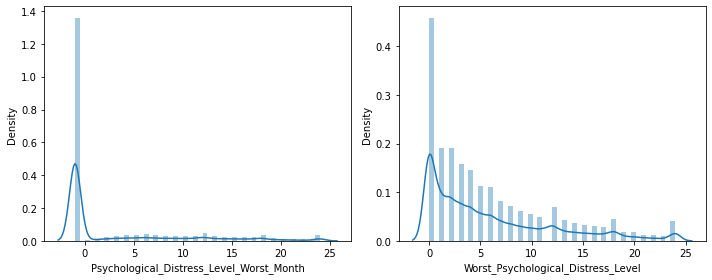

In [21]:
fig = plt.figure(1, (10, 4))

ax = plt.subplot(1,2,1)
sns.distplot(df.Psychological_Distress_Level_Worst_Month)
plt.tight_layout()

ax = plt.subplot(1,2,2)
sns.distplot(df.Worst_Psychological_Distress_Level)
plt.tight_layout()

plt.show()

# Multivariate Analysis & Multicollinearity

**Multicollinearity** (or collinearity) occurs when one independent variable in a regression model is linearly correlated with another independent variable.

**Problems That Arise From Multicollinearity**

1. The fitted regression coefficients (beta hat) will change substantially if one of the values of one of the x variables is changed only a bit.

2. The variance of the estimated coefficients will be inflated, which means that it will be hard to detect statistical significance. Furthermore, it’s possible that the F statistic is significant but the individual t statistics are not.

3. Ultimately, multicollinearity makes prediction less accurate. For a given model, the underlying assumption is that the relationships among the predicting variables, as well as their relationship with the target variable, will be the same. However, when multicollinearity is present, this is less likely to be the case.

**How to Detect and Eliminate Multicollinearity** Variance inflation factor or the IVF for each predicting variable. A VIF of 1 (the minimum possible VIF) means the tested predictor is not correlated with the other predictors.A VIF of 1 (the minimum possible VIF) means the tested predictor is not correlated with the other predictors.An acceptable VIF is if it’s less than the max of 10 and 1/1-R²model.

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [23]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [26]:
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
50,Moderate_Mental_Illness_Indicator_Past_Year,inf
49,Serious_Or_Moderate_Mental_Illness_Indicator_P...,inf
48,Serious_Mental_Illness_Indicator_Past_Year,inf
52,Low_Or_Moderate_Mental_Illness_Indicator_Past_...,inf
53,Categorical_Mental_Illness_Indicator,inf
54,Serious_Mental_Illness_And_Substance_Abuse,inf
55,Any_Mental_Illness_And_Substance_Abuse,inf
56,Low_Or_Moderate_Mental_Illness_And_Substance_A...,inf
51,Mild_Mental_Illness_Indicator_Past_Year,inf
19,Rehab_Paid,2839.778477


In [32]:
X2 = X.drop(['Moderate_Mental_Illness_Indicator_Past_Year', 
                            'Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year', 
                            'Serious_Mental_Illness_Indicator_Past_Year',
                            'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year', 
                            'Categorical_Mental_Illness_Indicator',
                            'Serious_Mental_Illness_And_Substance_Abuse', 
                            'Low_Or_Moderate_Mental_Illness_And_Substance_Abuse',
                            'Mild_Mental_Illness_Indicator_Past_Year', 
                            'Self_Paid', 
                            'Private_Health_Insurance_Paid',
                            'Medicare_Paid',
                            'Medicaid_Paid',
                            'Rehab_Paid',
                            'Employer_Paid',
                            'Military_Paid',
                            'Other_Public_Source_Paid',
                            'Other_Private_Source_Paid',
                            'Non_Household_Member_Paid',
                            'Age_Category',
                            'Age_Category_Three_Levels',
                            'Age_Category_Five_Levels',
                            'Gender_Age_Category',
                            'Race_Age'], axis=1)
vif_data2 = pd.DataFrame()
vif_data2["feature"] = X2.columns
vif_data2["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(len(X2.columns))]
vif_data2.sort_values(by='VIF', ascending=False)

,feature,VIF
0,Year,459.928984
1,Inpatient_Past_Year,1.761585
2,Outpatient_Past_Year,32.763501
3,Prescription_Treatment_Past_Year,46.237839
4,Any_Treatment_Past_Year,11.516696
5,Treatment_Type_Past_Year,63.634791
6,Perceived_Unmet_Need,25.037596
7,Received_Treatment_At_Clinic_Or_Center,2.270672
8,Received_Treatment_At_Private_Therapist,3.629939
9,Received_Treatment_At_NonClinic_Doctor,1.899808


In [33]:
vif_data2.sort_values(by='VIF', ascending=False)

,feature,VIF
0,Year,459.928984
28,No_Treatment_No_Transport_Inconvenient,221.697369
27,No_Treatment_Didn’t_Want_Others_To_Know,190.066444
18,No_Treatment_Insurance_Not_Covered,177.262357
21,No_Treatment_Confidentiality_Concerns,151.712366
17,No_Treatment_Feared_Effect_On_Job,150.274001
25,No_Treatment_Didn’t_Think_Would_Help,146.857704
23,No_Treatment_Didnt_Think_Needed,138.329201
29,No_Treatment_Other,128.118662
16,No_Treatment_Feared_Neighbors_Opinion,125.374202


In [34]:
X3 = X2.drop(['No_Treatment_No_Transport_Inconvenient',
             'No_Treatment_Confidentiality_Concerns',
             'No_Treatment_Didn’t_Think_Would_Help',
             'No_Treatment_Didnt_Think_Needed',
             'No_Treatment_Other',
             'No_Treatment_Feared_Neighbors_Opinion',
             'No_Treatment_Insurance_Not_Covered_Enough',
             'No_Treatment_Fear_Of_Being_Committed',
             'No_Treatment_Handle_Problem_Without',
             'No_Treatment_Didn’t_Have_Time',
             'No_Treatment_Where_To_Go'], axis=1)
vif_data3 = pd.DataFrame()
vif_data3["feature"] = X3.columns
vif_data3["VIF"] = [variance_inflation_factor(X3.values, i) for i in range(len(X3.columns))]
vif_data3.sort_values(by='VIF', ascending=False)

,feature,VIF
0,Year,402.205156
17,No_Treatment_Insurance_Not_Covered,156.487559
16,No_Treatment_Feared_Effect_On_Job,123.538911
18,No_Treatment_Didn’t_Want_Others_To_Know,122.612155
54,Total_Income_Family,118.144982
14,Nobody_Paid,115.487116
56,Total_Income_Family_Recode,81.676783
46,Covered_By_Any_Health_Insurance_Imputation_Rev...,60.382579
5,Treatment_Type_Past_Year,60.251661
15,No_Treatment_Could_Not_Afford,51.033305


In [36]:
X4 = X3.drop(['No_Treatment_Insurance_Not_Covered',
             'No_Treatment_Feared_Effect_On_Job',
              'Total_Income_Family_Recode',
              'Covered_By_Any_Health_Insurance',
              'Has_Medicare',
              'Has_Private_Health_Insurance',
              'Has_Other_Health_Insurance',
              'Has_Medicaid_Or_CHIP',
              'Has_Military_Benefit'], axis=1)
vif_data4 = pd.DataFrame()
vif_data4["feature"] = X4.columns
vif_data4["VIF"] = [variance_inflation_factor(X4.values, i) for i in range(len(X4.columns))]
vif_data4.sort_values(by='VIF', ascending=False)

,feature,VIF
0,Year,329.619950
14,Nobody_Paid,115.465561
16,No_Treatment_Didn’t_Want_Others_To_Know,105.852702
5,Treatment_Type_Past_Year,57.288507
15,No_Treatment_Could_Not_Afford,43.708331
3,Prescription_Treatment_Past_Year,41.636924
48,Poverty_Level,34.613511
49,Population_Density_2010,33.490631
2,Outpatient_Past_Year,31.039755
37,Adult_Employment_Status,27.798633


In [37]:
X5 = X4.drop(['No_Treatment_Could_Not_Afford',
             'No_Treatment_Didn’t_Want_Others_To_Know',
              'Population_Density_2010',
              'Received_Treatment_At_Clinic_Or_Center',
              'Received_Treatment_At_Medical_Clinic',
              'Received_Treatment_At_NonClinic_Doctor',
              'Received_Treatment_At_Private_Therapist',
              'Received_Treatment_Other',
              'Received_Treatment_At_Day_Hospital',
             'Received_Treatment_At_School'], axis=1)
vif_data5 = pd.DataFrame()
vif_data5["feature"] = X5.columns
vif_data5["VIF"] = [variance_inflation_factor(X5.values, i) for i in range(len(X5.columns))]
vif_data5.sort_values(by='VIF', ascending=False)

,feature,VIF
0,Year,184.340744
7,Nobody_Paid,98.899786
5,Treatment_Type_Past_Year,36.107648
39,Poverty_Level,34.590942
28,Adult_Employment_Status,27.787381
3,Prescription_Treatment_Past_Year,27.378484
37,Total_Income_Family,26.522880
19,Adult_Received_Counseling_Or_Meds_For_Depressi...,18.230358
25,Work_Situation_Past_Week,14.793610
21,Age_Category_Six_Levels,14.483686


In [38]:
corrmat = X5.corr()

In [39]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

In [40]:
# print out the linear correlation coefficients for each pair of variables in your data set, 
# in order of the correlation coefficient. 
# This lets you see very easily which pair of variables are most highly correlated.
mosthighlycorrelated(X5, 20) 

,FirstVariable,SecondVariable,Correlation
0,Outpatient_Past_Year,Nobody_Paid,0.926165
1,Work_Situation_Past_Week,Adult_Employment_Status,0.917838
2,Prescription_Treatment_Past_Year,Treatment_Type_Past_Year,0.896735
3,Adult_Lifetime_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressi...,0.896681
4,Any_Treatment_Past_Year,Treatment_Type_Past_Year,0.888502
5,Family_Receives_Food_Stamps,Participated_In_One_Or_More_Government_Assista...,0.880090
6,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,0.877687
7,Total_Income_Family,Poverty_Level,0.851050
8,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,0.827469
9,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_...,0.816006


In [42]:
# remove: 
#     Outpatient_Past_Year, Work_Situation_Past_Week,Prescription_Treatment_Past_Year, 
#     Adult_Lifetime_Major_Depressive_Episode, Any_Treatment_Past_Year, Family_Receives_Food_Stamps,
#     Suicide_Attempt_Past_Year
X6  = X5.drop(['Outpatient_Past_Year', 'Work_Situation_Past_Week', 'Prescription_Treatment_Past_Year',
              'Adult_Lifetime_Major_Depressive_Episode', 'Any_Treatment_Past_Year', 'Family_Receives_Food_Stamps',
              'Suicide_Attempt_Past_Year'], axis=1)
vif_data6 = pd.DataFrame()
vif_data6["feature"] = X6.columns
vif_data6["VIF"] = [variance_inflation_factor(X6.values, i) for i in range(len(X6.columns))]
vif_data6.sort_values(by='VIF', ascending=False)

,feature,VIF
0,Year,92.617703
32,Poverty_Level,34.454056
30,Total_Income_Family,26.466024
4,Nobody_Paid,23.178375
16,Age_Category_Six_Levels,14.461515
18,Education_Category,12.275884
15,Gender,11.677032
8,Worst_Psychological_Distress_Level,9.836653
23,Covered_By_Any_Health_Insurance_Imputation_Rev...,9.348049
29,Total_Income_Respondent,8.340940


In [50]:
X7  = X6.drop(['Poverty_Level', 'Year', 'Worst_Psychological_Distress_Level', 'Family_Receives_Welfare_JobPlacement_Childcare',
              'Psychological_Distress_Level_Worst_Month', 'Family_Receives_Social_Security', 'County_Metro_NonMetro_Status',
              'Total_Income_Family', 'Serious_Suicidal_Thoughts_Past_Year', 'Nobody_Paid', 'Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year',
              'Family_Receives_SSI', 'Months_On_Welfare'], axis=1)
vif_data7 = pd.DataFrame()
vif_data7["feature"] = X7.columns
vif_data7["VIF"] = [variance_inflation_factor(X7.values, i) for i in range(len(X7.columns))]
vif_data7.sort_values(by='VIF', ascending=False)

,feature,VIF
10,Age_Category_Six_Levels,11.429035
12,Education_Category,10.276931
9,Gender,9.607584
17,Covered_By_Any_Health_Insurance_Imputation_Rev...,8.324506
13,Overall_Health,6.950839
19,Total_Income_Respondent,6.458151
16,Adult_Employment_Status,5.195010
11,NEWRACE2,2.128714
5,Serious_Psychological_Distress_Indicator_Past_...,1.944473
3,Num_Weeks_Mental_Health_Difficulties,1.900858


In [53]:
mosthighlycorrelated(X7, 5) 

,FirstVariable,SecondVariable,Correlation
0,Serious_Psychological_Distress_Indicator_Past_...,Adult_Past_Year_Major_Depressive_Episode,0.476840
1,Num_Weeks_Mental_Health_Difficulties,Serious_Psychological_Distress_Indicator_Past_...,0.452741
2,Num_Weeks_Mental_Health_Difficulties,Adult_Past_Year_Major_Depressive_Episode,0.433599
3,Adult_Employment_Status,Total_Income_Respondent,-0.431862
4,Education_Category,Total_Income_Respondent,0.422501


In [54]:
X7.shape

(214505, 21)

# Forward selection

In [62]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LogisticRegression(),
          k_features=10,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv = 0)

sfs.fit(X7, y)
sfs.k_feature_names_  

# ('Treatment_Type_Past_Year',
#  'Perceived_Unmet_Need',
#  'Num_Weeks_Mental_Health_Difficulties',
#  'Serious_Psychological_Distress_Indicator_Past_Year',
#  'Suicide_Plan_Past_Year',
#  'Any_Mental_Illness_And_Substance_Abuse',
#  'Adult_Past_Year_Major_Depressive_Episode',
#  'Gender',
#  'Age_Category_Six_Levels',
#  'Education_Category')

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

('Treatment_Type_Past_Year',
 'Perceived_Unmet_Need',
 'Num_Weeks_Mental_Health_Difficulties',
 'Serious_Psychological_Distress_Indicator_Past_Year',
 'Suicide_Plan_Past_Year',
 'Any_Mental_Illness_And_Substance_Abuse',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Gender',
 'Age_Category_Six_Levels',
 'Education_Category')

In [65]:
# Instantiate the estimator - LogisticRegression

lr = LogisticRegression(C=1.0, random_state=1)

# Number of features
k_features = 10

# Instantiate SequentialBackwardSearch
sfs = SequentialForwardSelection(lr, k_features)

# Fit the data to determine the k_features which give the
# most optimal model performance
sfs.fit(X7,y)

NameError: name 'SequentialForwardSelection' is not defined

In [ ]:
k_features = [len(k) for k in sfs.subsets_]
plt.plot(k_features, sfs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

# Backward selection

In [63]:
#Sequential backward selection(sbs)
sbs = SFS(LogisticRegression(),
         k_features=10,
         forward=False,
         floating=False,
         scoring = 'accuracy',
         cv=0)
sbs.fit(X7, y)
sbs.k_feature_names_

# ('Inpatient_Past_Year',
#  'Treatment_Type_Past_Year',
#  'Perceived_Unmet_Need',
#  'Num_Weeks_Mental_Health_Difficulties',
#  'Serious_Psychological_Distress_Indicator_Past_Year',
#  'Suicide_Plan_Past_Year',
#  'Any_Mental_Illness_And_Substance_Abuse',
#  'Adult_Past_Year_Major_Depressive_Episode',
#  'Age_Category_Six_Levels',
#  'Adult_Employment_Status')

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

('Inpatient_Past_Year',
 'Treatment_Type_Past_Year',
 'Perceived_Unmet_Need',
 'Num_Weeks_Mental_Health_Difficulties',
 'Serious_Psychological_Distress_Indicator_Past_Year',
 'Suicide_Plan_Past_Year',
 'Any_Mental_Illness_And_Substance_Abuse',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Age_Category_Six_Levels',
 'Adult_Employment_Status')

# Bi-directional elimination (Stepwise Selection)

In [66]:
# Sequential Forward Floating Selection(sffs)
sffs = SFS(LogisticRegression(),
         k_features=(10),
         forward=True,
         floating=True,
         scoring = 'accuracy',
         cv=0)
sffs.fit(X7, y)
sffs.k_feature_names_

# ('Treatment_Type_Past_Year',
#  'Perceived_Unmet_Need',
#  'Num_Weeks_Mental_Health_Difficulties',
#  'Num_Days_Past_Year_Unable_To_Work',
#  'Serious_Psychological_Distress_Indicator_Past_Year',
#  'Suicide_Plan_Past_Year',
#  'Any_Mental_Illness_And_Substance_Abuse',
#  'Adult_Past_Year_Major_Depressive_Episode',
#  'Age_Category_Six_Levels',
#  'Adult_Employment_Status')

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

('Treatment_Type_Past_Year',
 'Perceived_Unmet_Need',
 'Num_Weeks_Mental_Health_Difficulties',
 'Num_Days_Past_Year_Unable_To_Work',
 'Serious_Psychological_Distress_Indicator_Past_Year',
 'Suicide_Plan_Past_Year',
 'Any_Mental_Illness_And_Substance_Abuse',
 'Adult_Past_Year_Major_Depressive_Episode',
 'Age_Category_Six_Levels',
 'Adult_Employment_Status')